# Разработка модели

В этой тетрадке вы должны создать свою модель и сохранить ее веса, чтобы потом их можно было загрузить уже из телеграм бота. Сейчас здесь находится бейзлайн, который вам нужно адаптировать под свой датасет. Идеологически этот проект про ислледовательскую работу, мы хотим, чтобы Вы научились решать задачу классификации с нуля. Поэтому основное время всего проекта должно занять создание модели и ее оптимизация. 

В качестве фреймворка для всей работы мы предлагаем Вам fast.ai. Эта бибилотека содержит очень много полезных инструментов и проста в освоении. По fast ai есть курс, но он использует устаревшую версию библиотеки, которую нужно устанавливать, копируя папку с гитхаба. Если Вы установили библиотеку через pip, то используйте документацию https://docs.fast.ai/vision.html#vision

Список вещей, которые стоит сделать в проекте.  
* Подберите лучшую модель
* Используте LrFinder
* Поберите стратегию для изменения learning rate
* Используйте аугментации на обучающем датасете.
* Используйте Test Time Augmentation (классфификация по-разному аугментированной картинки и усреднение предсказаний).

Не ограничивайтесь этим списком и попытайтесь найти или придумать другие пути для улучшения своей модели, креативность только приветствуется. 

Во время разработки в этой тетради может содрежаться много разного и несвязного кода, но к концу проекта постарайтесь оформить тетрадку с одной моделью, чтобы другие люди могли использовать вашу работу.

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

from fastai.vision import *

plt.ion()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/DLproject/dataset.zip -d dataset

# В этой части нужно загрузить датасет, разделить его на тренировочную и валидационную выборки и разложить картинки по папкам, чтобы в одной папке лежали картинки одного класса.

Эта часть очень сильно зависит от датасета, который вы выбрали, поэтому включить ее в бейзлайн не получится. Если вы выберете датасет, но застрянете на этом шаге, то напишите мне и я помогу разобраться. Это очень важно и не стоит откладывать, так как без приведения датасета к удобному формату вы не сможете продолжить проект.

В моем случае нужно просто загрузить датасет с каггла и распаковать https://www.kaggle.com/joosthazelzet/lego-brick-images/version/1 

In [0]:
from pathlib import Path
PATH = Path('/content/dataset/images')
data = ImageDataBunch.from_folder(PATH,valid_pct=0.2, ds_tfms=get_transforms(do_flip=False,flip_vert=False, max_rotate=0,max_lighting=0.3),bs=64, size=299, num_workers=0).normalize(imagenet_stats)

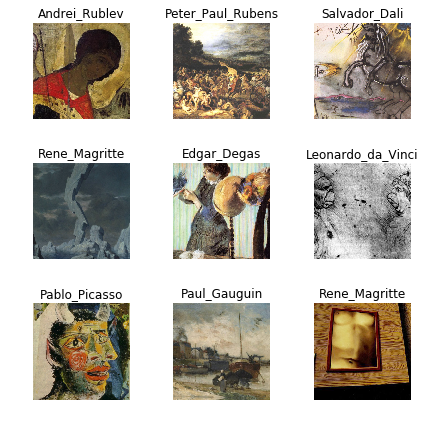

In [5]:
data.show_batch(rows=3, figsize=(6,6))

# Теперь перейдем к созданию модели

In [5]:
# если мы создаем предобученную модель, то все слои, кроме последних полносвязных будут заморожены,
# стоит помнить об этом при обучении
model = create_cnn(data, models.resnet50, metrics=accuracy)
model.fit_one_cycle(3)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 53918824.99it/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.543483,0.958956,0.731250,15:42
1,0.974298,0.632529,0.816369,15:21
2,0.653515,0.535649,0.846726,15:11


# Оставлось обучить модель и проверить ее точность.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-06


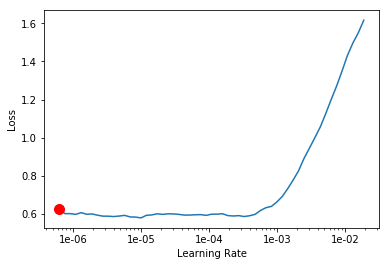

In [6]:
# Здесь мы используем lr_finder, чтобы выбрать скорость обучения
model.unfreeze()
model.lr_find()
model.recorder.plot(suggestion=True)

In [7]:
# используем 1cycle policy подрбнее https://docs.fast.ai/callbacks.one_cycle.html
model.fit_one_cycle(3,6.31e-07)

epoch,train_loss,valid_loss,accuracy,time
0,0.582219,0.534212,0.844940,16:24
1,0.574947,0.526719,0.848214,16:20
2,0.567335,0.524043,0.850298,16:18


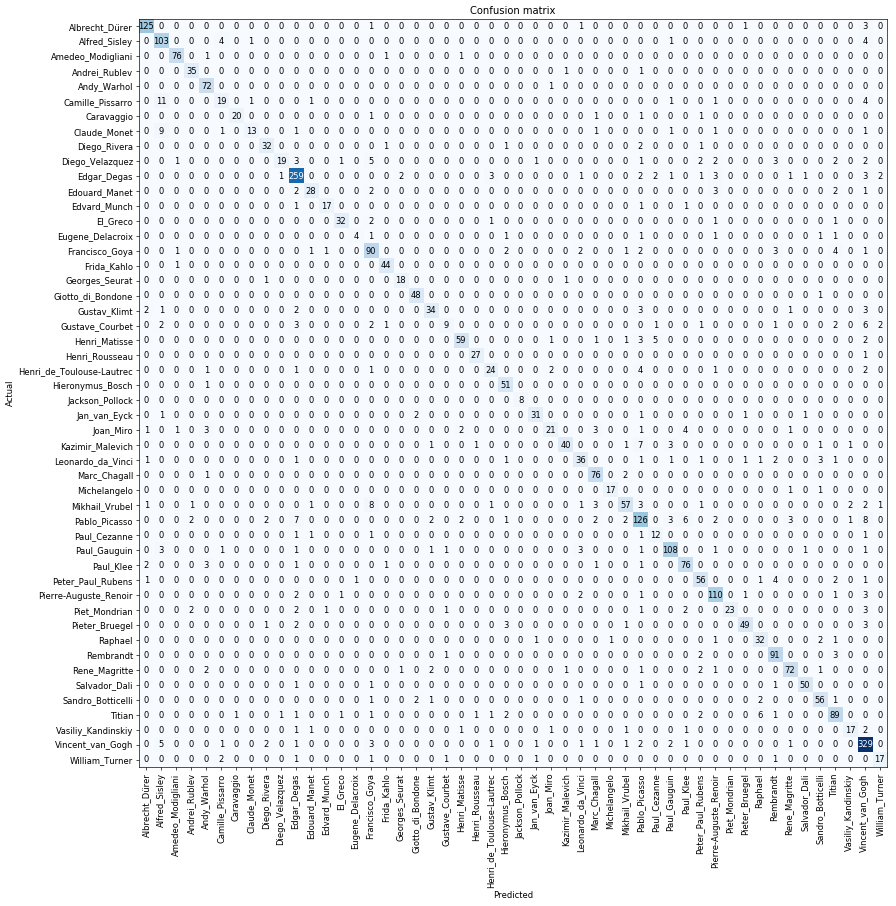

In [8]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(15,15), dpi=60)

# Сохраним веса

In [0]:
model.export()

В улучшении бейзлайна и получении новых идей Вам сильно поможет документация fast ai. Начать стоит с раздела про vision, а потом посмотреть туториалы, чтобы понимать на что вообще способна библиотека.

Из интересных идей, которые можно попробовать: можно проводить пару эпох обучения сначала на более маленьких картинках, чем итоговые (тогда при обучении на больших картинках у сети уже будут более менее неплохие веса). 